# 사전과제 1
- ‘더치페이 요청에 대한 응답률이 높을수록 더치페이 서비스를 더 많이 사용한다.’라는 가설을 통계적으로 검정해주세요.
- 해당 가설 검정 방법을 선택한 이유와 함께 전체 검정 과정을 기술해주세요.

'더치페이 요청에 대한 응답률이 높을수록 더치페이 서비스를 더 많이 사용한다'는 가설은  
'더치페이 요청에 응답(SEND)를 한 유저가 더치페이 요청도 많이 할 것이다'와 같은 말로 해석된다.   
이를 위해, 각 유저의 더치페이 응답율과, 그 유저들의 더치페이 요청수를 추출하여 이 두 feature가 얼마나 연관되어 있는지 상관관계를 보고자 한다.

In [1]:
import pandas as pd #DataFrame을 위한 라이브러리
from scipy import stats #검정을 위한 라이브러리

### 더치페이 요청 데이터 중 응답율을 추출 


In [2]:
#더치페이 요청 데이터 불러오기
file_path = 'dutchpay_claim_detail.csv' 
dutch_receive = pd.read_csv(file_path) 

#더치페이 요청을 받은 유저가 요청을 몇번이나 받았는지 카운트
dutch_receive_count = dutch_receive.groupby('recv_user_id')['claim_id'].count().to_frame()
dutch_receive_count.columns=['recv_cnt']
dutch_receive_count.index.name = 'recv_user_id'
dutch_receive_count = dutch_receive_count['recv_cnt'].astype('float')

#더치페이 요청을 받은 유저가 몇번이나 응답을 했는지 카운트
#응답률은 단순히 check가 아니라 send를 기준으로 한다!
dutch_receive_send = dutch_receive[dutch_receive.status == 'SEND'] #status가 send인 것만 발라낸다.
dutch_receive_send = dutch_receive_send.groupby('recv_user_id')['claim_id'].count().to_frame()
dutch_receive_send.columns=['send_cnt']
dutch_receive_send.index.name = 'recv_user_id'
dutch_receive_send = dutch_receive_send['send_cnt'].astype('float')

#더치페이 요청을 받은 유저의 응답률(send)은 얼마인지 알기 위해 Left Join 
dutch_receive_respond = pd.merge(dutch_receive_count, dutch_receive_send, how='left', on='recv_user_id')

#Send가 없는 유저들은 0으로 변경
dutch_receive_respond['send_cnt'] = dutch_receive_respond['send_cnt'].fillna(0)

#소수점 3자리까지 표기
pd.options.display.float_format = '{:.3f}'.format

#응답률로 변경
dutch_respond_percent = dutch_receive_respond['send_cnt']/dutch_receive_respond['recv_cnt']*100
dutch_respond_percent = dutch_respond_percent.to_frame()
dutch_respond_percent.columns=['percentage']
dutch_respond_percent.index.name = 'recv_user_id'

### 더치페이 요청을 한 사람을 추출

In [3]:
#더치페이 요청을 한 사람
file_path = 'dutchpay_claim.csv'
dutch_claim = pd.read_csv(file_path)
dutch_claim_count = dutch_claim.groupby('claim_user_id')['claim_id'].count().to_frame()
dutch_claim_count.columns=['claim_cnt']
dutch_claim_count.index.name = 'recv_user_id' #유저에 대한 컬럼명(인덱스) 통일화

### 응답율과 비교하기 위해 한개 DataFrame으로 만듬

In [4]:
#Left join으로 응답율과 요청수를 합침
dutch = pd.merge(dutch_respond_percent, dutch_claim_count, on='recv_user_id', how='left')
#요청수가 없는 유저들은 0으로 변경
dutch['claim_cnt'] = dutch['claim_cnt'].fillna(0)

In [5]:
#상관계수 'pearson'
corr = dutch[['percentage','claim_cnt']].corr(method = 'pearson')
print(corr)

            percentage  claim_cnt
percentage       1.000     -0.151
claim_cnt       -0.151      1.000


### 일단 상관계수가 -0.151이 나왔으므로 큰 상관이 없는 것으로 추측된다.   
### 오히려 음수가 나왔으므로 더치페이에 대한 응답율과 더치페이 사용수는 약한 음의 상관관계가 있는 것으로 보인다.       



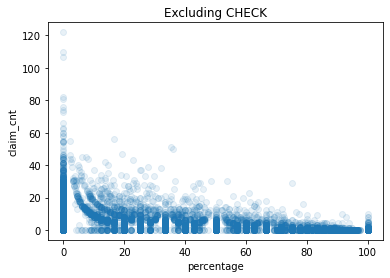

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

#데이터 확인을 위한 분포표 
plt.scatter(dutch['percentage'], dutch['claim_cnt'], alpha=0.1)
plt.xlabel("percentage")
plt.ylabel("claim_cnt")
plt.title('Excluding CHECK')
plt.show()

### 혹시 응답률을 SEND로만 봐서 그런건 아닐까? CHECK까지 포함해 보자

In [7]:
#더치페이 요청을 받은 유저가 몇번이나 응답을 했는지 카운트
#응답률은 send와 check를 모두를 본다!
dutch_receive_send2 = dutch_receive[(dutch_receive['status'] == 'SEND') | (dutch_receive['status'] == 'CHECK')]
dutch_receive_send2 = dutch_receive_send2.groupby('recv_user_id')['claim_id'].count().to_frame()
dutch_receive_send2.columns=['send_cnt']
dutch_receive_send2.index.name = 'recv_user_id'
dutch_receive_send2 = dutch_receive_send2['send_cnt'].astype('float')

In [8]:
#아래 데이터처리는 모두 같으므로 그냥 변수 선언만 뒤에 2를 붙여 계산한다.

#더치페이 요청을 받은 유저의 응답률(send or check)은 얼마인지 알기 위해 Left Join 
dutch_receive_respond2 = pd.merge(dutch_receive_count, dutch_receive_send2, how='left', on='recv_user_id')

#Send가 없는 유저들은 0으로 변경
dutch_receive_respond2['send_cnt'] = dutch_receive_respond2['send_cnt'].fillna(0)

#응답률로 변경
dutch_respond_percent2 = dutch_receive_respond2['send_cnt']/dutch_receive_respond2['recv_cnt']*100
dutch_respond_percent2 = dutch_respond_percent2.to_frame()
dutch_respond_percent2.columns=['percentage']
dutch_respond_percent2.index.name = 'recv_user_id'

#Left join으로 응답율과 요청수를 합침
dutch2 = pd.merge(dutch_respond_percent2, dutch_claim_count, on='recv_user_id', how='left')
#요청수가 없는 유저들은 0으로 변경
dutch2['claim_cnt'] = dutch2['claim_cnt'].fillna(0)

#상관계수 'pearson'
corr = dutch2[['percentage','claim_cnt']].corr(method = 'pearson')
print(corr)

            percentage  claim_cnt
percentage       1.000      0.265
claim_cnt        0.265      1.000


###    CHECK를 추가해도 상관계수가 0.265가 나왔으므로 역시 큰 상관이 없는 것으로 보인다.   

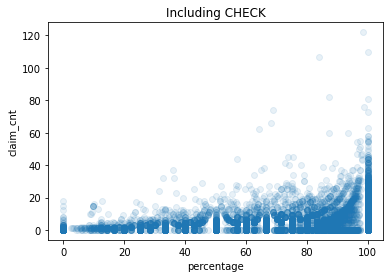

In [9]:
#데이터 확인을 위한 분포표 
plt.scatter(dutch2['percentage'], dutch2['claim_cnt'], alpha=0.1)
plt.xlabel("percentage")
plt.ylabel("claim_cnt")
plt.title('Including CHECK')
plt.show()

### 이에 더치페이 응답률과 사용성에는 큰 상관 관계가 없어 보인다.
### 응답률에 대한 정의 (CHECK를 응답인지, 아니면 SEND까지가 응답인지)에 따라 달라지기도 하고,
### 낮은 상관관계에서 응답과 사용의 인과관계를 따지는 것도 의미가 적다고 보여진다. 

## 따라서 결론은 응답율의 정의에 따라 사용성이 높아지기도 하고, 낮아지기도 하지만 큰 상관관계는 없다라고 말할 수 있다.